In [1]:
import qiskit
import numpy as np

c:\users\lenovo\appdata\local\programs\python\python36\lib\site-packages\qiskit\__init__.py:67: DeprecationWarning: Using Qiskit with Python 3.6 is deprecated as of the 0.17.0 release. Support for running Qiskit with Python 3.6 will be removed in a future release.
  "future release.", DeprecationWarning)


In [135]:
from qiskit import QuantumCircuit

def initCircuit(n):
    circuit = QuantumCircuit(2 * n)
    senders = circuit.qubits[0:n]
    receivers = circuit.qubits[n:]
    
    for sender, receiver in zip(senders, receivers):
        circuit.h(sender)
        circuit.cx(sender, receiver)
        
    return senders, receivers, circuit

#### Test 1: Init citcuit

In [160]:
senders_test, receivers_test, circuit_test = initCircuit(2)
circuit_test.draw()

┌───┐          
q_0: ┤ H ├──■───────
     ├───┤  │       
q_1: ┤ H ├──┼────■──
     └───┘┌─┴─┐  │  
q_2: ─────┤ X ├──┼──
          └───┘┌─┴─┐
q_3: ──────────┤ X ├
               └───┘

In [159]:
circuits_bits = dict()

def operate(circuit, target, bits):
    """
        => Z^(b_1) * X^(b_2)
    """
    if bits[0] == '1':
        circuit.z(target)
    if bits[1] == '1':
        circuit.x(target)

    return circuit

def getCircuit(classical_bits):
    bits_str = ''.join(classical_bits)
    if bits_str in circuits_bits:
        return circuits_bits[bits_str].copy()
    
    """
        getCircuit(circuit, ["01", "10", "00"])
            => X(A1), Z(A2), I(A3)
    """
    # global circuit
    circuit_copy = circuit.copy()
    
    circuit_copy.barrier(senders)
    for i, sender in enumerate(senders):
        operate(circuit_copy, sender, classical_bits[i])
    
    # memoized
    circuits_bits[bits_str] = circuit_copy

    return circuit_copy

#### Test 2: Get citcuit

In [161]:
senders, receivers, circuit = initCircuit(2)
circuit_1011 = getCircuit(['10', '11'])
circuit_1011.draw()

┌───┐           ░ ┌───┐     
q_0: ┤ H ├──■────────░─┤ Z ├─────
     ├───┤  │        ░ ├───┤┌───┐
q_1: ┤ H ├──┼────■───░─┤ Z ├┤ X ├
     └───┘┌─┴─┐  │   ░ └───┘└───┘
q_2: ─────┤ X ├──┼───────────────
          └───┘┌─┴─┐             
q_3: ──────────┤ X ├─────────────
               └───┘

In [130]:
def generateCombs(n, combs, comb):
    """
        n = 3 => 000 ... 333
    """
    if len(comb) == n:
        combs.append(comb)
        
        return

    for i in range(4):
        generateCombs(n, combs, comb + str(i))

In [162]:
combs = []
generateCombs(2, combs, '')

print(combs)

['00', '01', '02', '03', '10', '11', '12', '13', '20', '21', '22', '23', '30', '31', '32', '33']


In [168]:
from collections import defaultdict

from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.extensions import HamiltonianGate

matrixes = [
    Pauli(label='I').to_matrix(),
    Pauli(label='X').to_matrix(),
    Pauli(label='Y').to_matrix(),
    Pauli(label='Z').to_matrix(),
]

Hermitians = defaultdict(list)

def buildU(n, p, time):
    H = np.zeros((2 ** n, 2 ** n)).astype('complex64')
    
    # global Hermitians
    if n in Hermitians:
        # global combs
        for comb in combs:
            temp = np.kron(matrixes[int(comb[0])], matrixes[int(comb[1])])
            
            for i in range(2, n):
                temp = np.kron(temp, matrixes[int(comb[i])])
                
            Hermitians[n].append(temp)
            
    for para, hermitian in zip(p, Hermitians[n]):
        H += para * hermitian
    
    # time: simulation time
    # return type => DensityMatrix (qiskit)
    U = HamiltonianGate(H, time)
    
    return U.to_matrix()

#### Test 3: build unitary U

In [170]:
n = 3
U1 = buildU(n, np.random.uniform(-1, 1, 2 ** (2*n)), time=1.2)
U2 = np.conj(U1).T # U-dagger
I = np.eye(2 ** n)

# U * U_dagger = I => unitary
# expected: true
np.allclose(U1 @ U2, I)

True

In [117]:
from qiskit.quantum_info import partial_trace, DensityMatrix
from qiskit.extensions import UnitaryGate

def generateRous(n, U, indexes):
    """
        generates subsystems' states
        indexes => indexes of qubits need to keep in subsystem
    """
    bits = ["00", "01", "10", "11"]
    rous = []
    
    # global combs
    for comb in combs:
        circuit = getCircuit( [bits[int(i)] for i in comb] )
        # cirq.ops.MatrixGate(U):
        # matrix representation => Unitary Gate in cirq
        circuit.append(UnitaryGate(U), senders)
        
        rous.append( partial_trace(DensityMatrix(circuit), indexes) )
    
    return rous

#### Test 4: calculate rou_AB

In [173]:
n = 2
tempU = buildU(n, np.random.uniform(-1, 1, 2 ** (2*n)), time=1.2)
rous = generateRous(n, tempU, [0, 2])

print(rous[0].data)
print(rous[4].data)

[[ 0.25223947-8.67361738e-19j -0.11398114+1.34811282e-01j
  -0.08834325-3.71137313e-02j -0.08462216+3.50382082e-02j]
 [-0.11398114-1.34811282e-01j  0.24776053+5.20417043e-18j
   0.02273906+1.46148693e-01j  0.08834325+3.71137313e-02j]
 [-0.08834325+3.71137313e-02j  0.02273906-1.46148693e-01j
   0.24776053+0.00000000e+00j  0.11398114-1.34811282e-01j]
 [-0.08462216-3.50382082e-02j  0.08834325-3.71137313e-02j
   0.11398114+1.34811282e-01j  0.25223947+1.19262239e-18j]]
[[ 0.25223947-8.67361738e-19j -0.11398114+1.34811282e-01j
  -0.08834325-3.71137313e-02j -0.08462216+3.50382082e-02j]
 [-0.11398114-1.34811282e-01j  0.24776053+5.20417043e-18j
   0.02273906+1.46148693e-01j  0.08834325+3.71137313e-02j]
 [-0.08834325+3.71137313e-02j  0.02273906-1.46148693e-01j
   0.24776053+0.00000000e+00j  0.11398114-1.34811282e-01j]
 [-0.08462216-3.50382082e-02j  0.08834325-3.71137313e-02j
   0.11398114+1.34811282e-01j  0.25223947+1.19262239e-18j]]


#### Test 5: fidelity

In [175]:
from qiskit.quantum_info import state_fidelity
from scipy.linalg import sqrtm

rou = np.array([[ 0.5, 0, 0, 0],
                 [ 0, 0.5, 0, 0],
                 [ 0, 0, 0, 0],
                 [ 0, 0, 0, 0]])

sigma = np.array([[ 0.5, 0, 0, 0],
              [ 0,   0, 0, 0   ],
              [ 0 ,  0, 0, 0   ],
              [0, 0, 0,  0.5]])

print(state_fidelity(rou, sigma))

rou_root = sqrtm(rou)
f = np.dot(rou_root, sigma)
f = np.dot(f, rou_root)
f = sqrtm(f)

print(np.trace(f))

0.2500000000000001
0.5


In [176]:
from qiskit.quantum_info import state_fidelity
from scipy.linalg import sqrtm

def sub_L(rou, sigma, loss_function):
    loss = 0
    
    if loss_function == "F":
        # fidelity
        rou_root = sqrtm(rou)
        f = np.dot(rou_root, sigma)
        f = np.dot(f, rou_root)
        f = sqrtm(f)
        
        return np.linalg.norm( np.trace(f) )

    elif loss_function == "D":
        # trace
        A = rou - sigma
        A_ = sqrtm( np.dot( A.conj().T, A ) )
        
        return 0.5 * np.linalg.norm( np.trace(A_) )

#     print(loss)
    return loss

#### Test 6: distance calculate

In [178]:
p = np.array([-0.96007332,  0.19811892,  0.02909524, -0.7903949 , -0.87109773,
        0.50548779,  0.93497829, -0.07709957,  0.8608604 , -0.0903555 ,
        0.57477598,  0.64402944,  0.26530859, -0.18519221, -0.45444989,
       -0.54795223])

n = 2
tempU = buildU(n, p, time=1.2)
rous = generateRous(n, tempU, [0, 2])
rou = rous[4].data
sigma = rous[7].data

print( sub_L(rou, sigma, 'D') )
print( sub_L(rou, sigma, 'F') )

0.5374300692441453
0.8410960192483641


In [179]:
def L(n, p, loss_function, time):
    U = buildU(n, p, time)
    rous = []
    for i in range(n):
        rous.append(generateRous(n, U, [i, i + n]))
    
    loss = 0.0
    size = 2 ** (2 * n)
    book = set()
    count = 0
    for i in range(size):
        for j in range(size):
            if i != j and f"{i},{j}" not in book:
                for k in range(n):
                    loss += sub_L(rous[k][i].data, rous[k][j].data, loss_function)
                    count += 1

                book.add(f"{i},{j}")
                book.add(f"{j},{i}")
    
    loss /= count
    if loss_function == "F":
        loss *= -1
    
    return loss

#### Test 7: loss calculate

In [180]:
p = np.array([-0.96007332,  0.19811892,  0.02909524, -0.7903949 , -0.87109773,
        0.50548779,  0.93497829, -0.07709957,  0.8608604 , -0.0903555 ,
        0.57477598,  0.64402944,  0.26530859, -0.18519221, -0.45444989,
       -0.54795223])

print( L(2, p, 'D', 0.2) )
print( L(2, p, 'F', 0.2) )

0.3584547684147862
-0.8971253009311064


In [181]:
def GradientCalculator(n, p, epsilon, loss_function, time):
    derivates = np.zeros(len(p))
    
    l_p = L(n, p, loss_function, time)
    for i, param in enumerate(p):
        p[i] += epsilon
        l_pe = L(n, p, loss_function, time)
        p[i] -= epsilon
        
        derivates[i] = (l_pe - l_p)
        
    return derivates / epsilon, l_p

In [182]:
params = []
losses = []

def SDCLearner(n, *, loss_function="D", epoch=1000, epsilon=0.01, time=0.2):
    """
        param: 
    """
    # 1. initialize the parameters with uniformly random nunbers
    size = 2 ** (2 * n)
    p = np.random.uniform(-1, 1, size)
    
    # Adam parameters:
    momentum, s = 0, 0
    alpha = 0.001
    belta1 = 0.9; belta2 = 0.999
    e = 1e-8
    
    global params
    global losses
    params = []
    losses = []

    t = 0
    while t < epoch:
        # repeat
        t += 1
        grad, loss = GradientCalculator(n, p, epsilon, loss_function, time)
        losses.append(loss)
        
        # Adam Optimizer
        momentum = belta1 * momentum + (1 - belta1) * grad
        s = belta2 * s + (1 - belta2) * (grad ** 2)
        m_ = momentum / (1 - belta1 ** t)
        s_ = s / (1 - belta2 ** t)

        # update parameters
        p = p - alpha * (m_ / ( s_ ** 0.5 + e ))
#         p = p - alpha * grad
        
        # log
        print('epoch: [{}/{}] - loss: {} end.'.format(t, epoch, loss))
    
    params = p

In [31]:
def findTime():
    times = [0.5, 0.7, 0.8, 0.9, 1, 1.2, 1.5, 1.8, 2, 2.5, 3, 3.2, 3.5, 4]
    
    def delta(targets):
        l = len(targets)
        d = 0
        for i in range(1, l):
            d += targets[i] - targets[i - 1]
        
        return -1 * d / (l - 1)
    
    print(':::::::::: D ::::::::::')
    for time in times:
        print(f'time:{time}, loss: D')
        SDCLearner(2, loss_function='D', epoch=5, time=time)
        print(f'loss: {losses[0]}, delta: {delta(losses)}')
        
    print(':::::::::: F ::::::::::')
    for time in times:
        print(f'time:{time}, loss: F')
        SDCLearner(2, loss_function='F', epoch=5, time=time)
        print(f'loss: {losses[0]}, delta: {delta(losses)}')


In [32]:
findTime()

:::::::::: D ::::::::::
time:0.5, loss: D
epoch: [1/5] - loss: 0.42321315539000803 end.
epoch: [2/5] - loss: 0.42211037051114075 end.
epoch: [3/5] - loss: 0.4210068817531635 end.
epoch: [4/5] - loss: 0.4199027108358312 end.
epoch: [5/5] - loss: 0.4187978513101292 end.
loss: 0.42321315539000803, delta: 0.0011038260199697086
time:0.7, loss: D
epoch: [1/5] - loss: 0.45536275332880766 end.
epoch: [2/5] - loss: 0.45373277380639027 end.
epoch: [3/5] - loss: 0.45210029543970154 end.
epoch: [4/5] - loss: 0.4504653527593729 end.
epoch: [5/5] - loss: 0.44882793914120617 end.
loss: 0.45536275332880766, delta: 0.0016337035469003724
time:0.8, loss: D
epoch: [1/5] - loss: 0.2248821792810777 end.
epoch: [2/5] - loss: 0.22310816349412962 end.
epoch: [3/5] - loss: 0.2213355622429803 end.
epoch: [4/5] - loss: 0.219564536947831 end.
epoch: [5/5] - loss: 0.21779517222529568 end.
loss: 0.2248821792810777, delta: 0.001771751763945506
time:0.9, loss: D
epoch: [1/5] - loss: 0.22440939588668113 end.
epoch: [2/

epoch: [2/5] - loss: -0.9286945114401673 end.
epoch: [3/5] - loss: -0.9320450228392861 end.
epoch: [4/5] - loss: -0.9352106155338625 end.
epoch: [5/5] - loss: -0.9381898626629523 end.
loss: -0.9251618372656981, delta: 0.003257006349313557


In [190]:
import pickle

def saveParams(params, n, loss_function):
    path = f"./data/params_{loss_function}_{n}.pkl"
    
    with open(path, 'wb') as file:
        pickle.dump(params, file)

In [191]:
# saveParams(params, n, 'D')

### Variational learning the SDC quantum protocol

In [183]:
n = 2 # SDC-n
senders, receivers, circuit = initCircuit(n)
circuit.draw()

combs = []
generateCombs(n, combs, '')

In [184]:
SDCLearner(n, loss_function="F", epoch=2, time=1.2)

epoch: [1/2] - loss: -0.7486989885885547 end.
epoch: [2/2] - loss: -0.750803170186863 end.


### SDC-2

In [192]:
import matplotlib.pyplot as plt 

palette = {
    "D": "skyblue", "F": "red"
}

def plotLosses(n, loss_function):
    path = f"./data/losses_{loss_function}_{n}.pkl"
    
    with open(path, 'rb') as data:
        y = pickle.load(data)
        x = range(1, len(y) + 1)
        
    plt.plot(x, y, color=palette[loss_function], linewidth=2.0, linestyle='--')
    
    return y

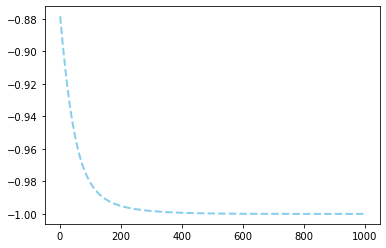

In [187]:
plotLosses(n, 'D')

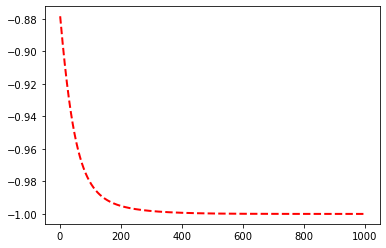

In [193]:
plotLosses(n, 'F')

In [195]:
def loadParams(n, loss_function):
    path = f"./data/params_{loss_function}_{n}.pkl"
    
    with open(path, 'rb') as file:
        params = pickle.load(file)
    
    return params

In [ ]:
p = 